In [72]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

from datetime import date

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

import configparser
config = configparser.ConfigParser()
config.read('config.ini')

import wandb
wandb.login()

2.9.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


True

In [73]:
name_of_run = 'wider-conv-layers-3-image-generator-penalization-100epoch'

In [74]:
run = wandb.init(project="convolutional-nn", id=name_of_run)

In [75]:
EPOCHS = config['default'].getint('epochs')
IMAGE_SIZE = config['default'].getint('image_size')
BATCH_SIZE = config['default'].getint('batch_size')
SEED = config['default'].getint('seed')
START_LR = config['default'].getfloat('start_lr')
MAX_LR = config['default'].getfloat('max_lr')
STEPS_PER_EPOCH = config['default'].getint('steps_per_epoch')
ANNEAL_STRATEGY = config['default']['strategy']

wandb.config.update({'epochs': EPOCHS, 
                     'image_size': IMAGE_SIZE, 
                     'batch_size': BATCH_SIZE,
                     'start_lr': START_LR,
                     'max_lr': MAX_LR, 
                     'strategy': ANNEAL_STRATEGY})

In [76]:
data_path = 'Data/original'

class_names = sorted(os.listdir(data_path))
num_classes = len(class_names)
print("Number of Classes:", num_classes)

class_sizes = []
for name in class_names:
    class_size = len(os.listdir(data_path + "/" + name))
    class_sizes.append(class_size)

print("Class Distribution:\n", dict(zip(class_names, class_sizes)))

Number of Classes: 10
Class Distribution:
 {'butterfly': 2112, 'cat': 1668, 'chicken': 3098, 'cow': 1866, 'dog': 4863, 'elephant': 1446, 'horse': 2623, 'sheep': 1820, 'spider': 4821, 'squirrel': 1862}


<AxesSubplot:title={'center':'Animal class distribution'}, ylabel='Animal'>

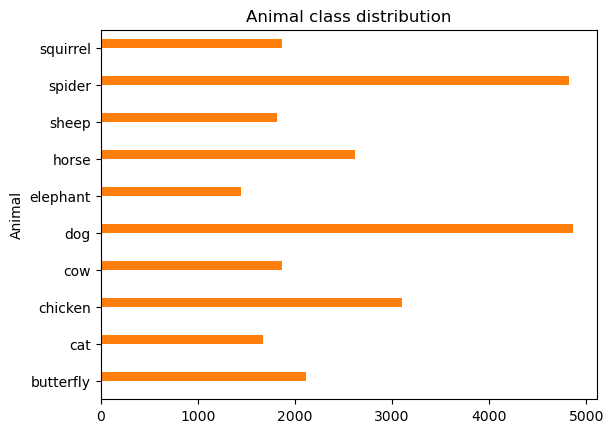

In [77]:
distribution = dict(zip(class_names, class_sizes))
distributionDf = pd.DataFrame.from_dict(distribution.items())
distributionDf.columns = ['Animal', 'Count']
distributionDf = distributionDf.reset_index()

distributionDf.plot.barh(x = 'Animal', title='Animal class distribution', legend = False)

In [78]:
distributionDf['Weight'] = distributionDf['Count'].sum() / distributionDf['Count']
distributionDf['Weight'] = distributionDf['Weight'] / distributionDf['Weight'].mean()
weights = distributionDf['Weight'].to_dict()

print(distributionDf)
weights

   index     Animal  Count    Weight
0      0  butterfly   2112  1.051237
1      1        cat   1668  1.331063
2      2    chicken   3098  0.716660
3      3        cow   1866  1.189825
4      4        dog   4863  0.456552
5      5   elephant   1446  1.535417
6      6      horse   2623  0.846440
7      7      sheep   1820  1.219897
8      8     spider   4821  0.460529
9      9   squirrel   1862  1.192381


{0: 1.0512369963861918,
 1: 1.3310626716832357,
 2: 0.7166599536370681,
 3: 1.1898245103792269,
 4: 0.45655203297709995,
 5: 1.5354166918171765,
 6: 0.8464401587371854,
 7: 1.2198969980041963,
 8: 0.46052946201361483,
 9: 1.1923805243650039}

In [79]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'Data/original',
  validation_split=0.2,
  subset="training",
  seed=SEED,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  'Data/original',
  validation_split=0.2,
  subset="validation",
  seed=SEED,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


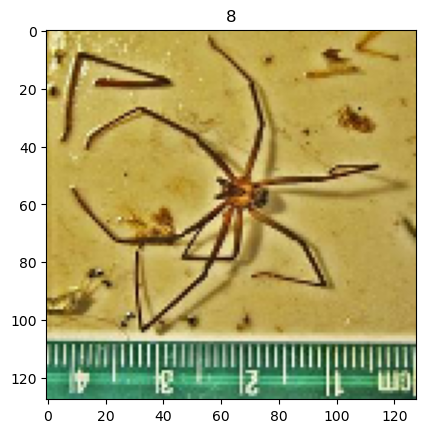

In [80]:
for images, labels in train_ds.take(1):
    plt.imshow(images[0].numpy().astype('uint8'))
    plt.title(labels[0].numpy())
    break

In [81]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


In [82]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [83]:
train_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
                  'Data/original',
                  target_size=(IMAGE_SIZE, IMAGE_SIZE),
                  batch_size=BATCH_SIZE,
                  shuffle=True,
                  subset='training',
                  class_mode='binary')

val_generator = train_datagen.flow_from_directory(
                  'Data/original',
                  target_size=(IMAGE_SIZE, IMAGE_SIZE),
                  batch_size=BATCH_SIZE,
                  shuffle=True,
                  subset='validation',
                  class_mode='binary')   

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


In [84]:
train_generator.class_indices

{'butterfly': 0,
 'cat': 1,
 'chicken': 2,
 'cow': 3,
 'dog': 4,
 'elephant': 5,
 'horse': 6,
 'sheep': 7,
 'spider': 8,
 'squirrel': 9}

In [85]:
def schedule(epoch):
    cycle = 0
    if epoch < (EPOCHS // 2):
        cycle = 1 + (epoch * STEPS_PER_EPOCH) // (EPOCHS // 2)
        factor = float(cycle * MAX_LR) / float(EPOCHS)
    else:
        cycle = 1 + ((EPOCHS - epoch) * STEPS_PER_EPOCH) // (EPOCHS // 2)
        factor = float(cycle * MAX_LR) / float(EPOCHS)
        factor = MAX_LR - factor

    if ANNEAL_STRATEGY == 'cos':
        lr = factor * (1 + tf.math.cos(tf.constant(np.pi) * (epoch % (EPOCHS // 2)) / (EPOCHS // 2))) / 2
    elif ANNEAL_STRATEGY == 'linear':
        lr = factor * (EPOCHS - epoch) / EPOCHS
    else:
        raise ValueError('Invalid anneal strategy')

    return lr

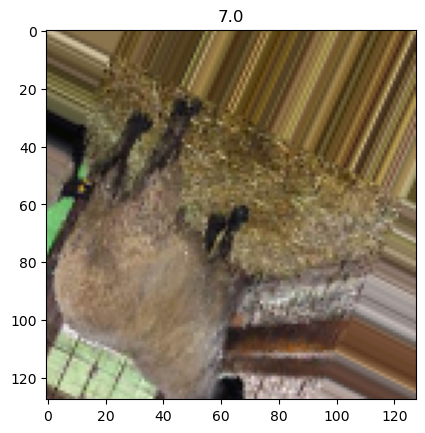

In [86]:
for images, labels in iter(train_generator):
    plt.imshow(images[0])
    plt.title(labels[0])
    break

In [87]:
class WandbCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        wandb.log(logs)

In [88]:
""" with tf.device('/cpu:0'):
  augment = tf.keras.Sequential([
      layers.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.2)
  ]) """

model = tf.keras.Sequential([
    #augment,

    layers.Conv2D(32, 3, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Activation('relu'),
    layers.Dense(10)
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
#lr_scheduler = LearningRateScheduler(schedule=schedule, verbose=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=0.0001)

metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(),
    tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)
]

model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_4 (Batc  (None, 64, 64, 64)      

In [89]:
callbacks = [WandbCallback(), 
             EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10, restore_best_weights=True), 
             ModelCheckpoint("model_checkpoint.h5", save_best_only=True)
             #reduce_lr
             ]

model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, callbacks=callbacks, class_weight=weights)

Epoch 1/100


2023-04-08 10:47:24.430849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  6/655 [..............................] - ETA: 1:02 - loss: 17.9432 - sparse_categorical_accuracy: 0.1146 - sparse_categorical_crossentropy: 18.4613WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0439s vs `on_train_batch_end` time: 0.0448s). Check your callbacks.


655/655 [==============================] - ETA: 0s - loss: 2.7727 - sparse_categorical_accuracy: 0.2001 - sparse_categorical_crossentropy: 3.2065

2023-04-08 10:48:31.801705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


655/655 [==============================] - 84s 127ms/step - loss: 2.7727 - sparse_categorical_accuracy: 0.2001 - sparse_categorical_crossentropy: 3.2065 - val_loss: 2.3268 - val_sparse_categorical_accuracy: 0.2114 - val_sparse_categorical_crossentropy: 2.3268
Epoch 2/100
655/655 [==============================] - 86s 132ms/step - loss: 1.6532 - sparse_categorical_accuracy: 0.2996 - sparse_categorical_crossentropy: 1.9574 - val_loss: 1.8847 - val_sparse_categorical_accuracy: 0.3461 - val_sparse_categorical_crossentropy: 1.8847
Epoch 3/100
655/655 [==============================] - 87s 132ms/step - loss: 1.5324 - sparse_categorical_accuracy: 0.3582 - sparse_categorical_crossentropy: 1.8153 - val_loss: 1.8403 - val_sparse_categorical_accuracy: 0.3435 - val_sparse_categorical_crossentropy: 1.8403
Epoch 4/100
655/655 [==============================] - 86s 131ms/step - loss: 1.4509 - sparse_categorical_accuracy: 0.3941 - sparse_categorical_crossentropy: 1.7185 - val_loss: 1.6233 - val_sparse

In [90]:
pd.DataFrame(model.history.history)

,loss,sparse_categorical_accuracy,sparse_categorical_crossentropy,val_loss,val_sparse_categorical_accuracy,val_sparse_categorical_crossentropy
0,2.772696,0.200124,3.206450,2.326812,0.211391,2.326812
1,1.653227,0.299566,1.957371,1.884747,0.346139,1.884747
2,1.532428,0.358237,1.815320,1.840253,0.343463,1.840253
3,1.450863,0.394138,1.718515,1.623325,0.433295,1.623325
4,1.382999,0.429178,1.636702,1.952404,0.349006,1.952404
5,1.299516,0.461594,1.533480,1.507119,0.478976,1.507119
6,1.253668,0.488328,1.477017,1.545120,0.468654,1.545120
7,1.221886,0.500788,1.441893,1.800508,0.387997,1.800508
8,1.188155,0.516017,1.399336,1.341200,0.539182,1.341200
9,1.166408,0.530673,1.375337,1.700382,0.422592,1.700382


In [91]:
model.evaluate(val_generator)

164/164 [==============================] - 16s 97ms/step - loss: 1.0423 - sparse_categorical_accuracy: 0.6537 - sparse_categorical_crossentropy: 1.0423


[1.0423204898834229, 0.6536697149276733, 1.0423204898834229]

In [92]:
tf.keras.models.save_model(model, f'model/{name_of_run}.pth')
wandb.save(f'runs/pima_run_{date.today().strftime("%Y-%m-%d")}-{name_of_run}')
wandb.finish()

INFO:tensorflow:Assets written to: model/wider-conv-layers-3-image-generator-penalization-100epoch.pth/assets


INFO:tensorflow:Assets written to: model/wider-conv-layers-3-image-generator-penalization-100epoch.pth/assets


loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▂▃▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇██████████████
sparse_categorical_crossentropy,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▆▄▄▃▅▃▃▃▂▃▂▆▂▄▃▄▂▂▃▂▆▂▂▂▂▂▁▄▁▁▁▂▃▃▂▂▁
val_sparse_categorical_accuracy,▁▃▃▃▅▅▆▄▆▆▆▇▆▇▄▆▆▆▅▇▇▆▇▄▇▇▇▇▇█▆███▇▆▆▇▇█
val_sparse_categorical_crossentropy,█▆▅▆▄▄▃▅▃▃▃▂▃▂▆▂▄▃▄▂▂▃▂▆▂▂▂▂▂▁▄▁▁▁▂▃▃▂▂▁
loss,0.78544
sparse_categorical_accuracy,0.68635
sparse_categorical_crossentropy,0.93333
val_loss,1.09101
val_sparse_categorical_accuracy,0.63054
